In [43]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from matplotlib import dates
import plotly.graph_objs as go
import plotly.offline as pyoff

#import Keras
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [44]:
df = pd.read_excel('itService.xlsx')

df = df.drop(['YY', 'MM'], axis=1)
df['YYMM'] = df['YYMM'].astype(str)
df['YYMM'] = df['YYMM'] + "01"
df['YYMM'] = pd.to_datetime(df['YYMM'])
df

,YYMM,CNT
0,2013-05-01,14
1,2013-06-01,70
2,2013-07-01,25
3,2013-08-01,15
4,2013-09-01,13
...,...,...
99,2021-08-01,127
100,2021-09-01,107
101,2021-10-01,137
102,2021-11-01,143


In [45]:
#create a new dataframe to model the difference
df_diff = df.copy()
#add previous sales to the next row
df_diff['prev_CNT'] = df_diff['CNT'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['CNT'] - df_diff['prev_CNT'])
df_diff.head(10)


,YYMM,CNT,prev_CNT,diff
1,2013-06-01,70,14.0,56.0
2,2013-07-01,25,70.0,-45.0
3,2013-08-01,15,25.0,-10.0
4,2013-09-01,13,15.0,-2.0
5,2013-10-01,19,13.0,6.0
6,2013-11-01,19,19.0,0.0
7,2013-12-01,40,19.0,21.0
8,2014-01-01,126,40.0,86.0
9,2014-02-01,82,126.0,-44.0
10,2014-03-01,82,82.0,0.0


In [46]:
df_diff = df_diff[df['YYMM'].between('2020-10-01', '2021-12-01')]
df_diff

C:\Users\admin\AppData\Local\Temp/ipykernel_24372/2212696282.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,YYMM,CNT,prev_CNT,diff
89,2020-10-01,10,21.0,-11.0
90,2020-11-01,7,10.0,-3.0
91,2020-12-01,13,7.0,6.0
92,2021-01-01,72,13.0,59.0
93,2021-02-01,325,72.0,253.0
94,2021-03-01,362,325.0,37.0
95,2021-04-01,264,362.0,-98.0
96,2021-05-01,163,264.0,-101.0
97,2021-06-01,200,163.0,37.0
98,2021-07-01,180,200.0,-20.0


In [47]:
#plot sales diff
plot_data = [
    go.Scatter(
        x=df_diff['YYMM'],
        y=df_diff['CNT'],
    )
]
plot_layout = go.Layout(
        title='ITService Count'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [48]:
#plot sales diff
plot_data = [
    go.Scatter(
        x=df_diff['YYMM'],
        y=df_diff['diff'],
    )
]
plot_layout = go.Layout(
        title='ITService Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [49]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_CNT'],axis=1)
#adding lags
for inc in range(1,6):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised

,YYMM,CNT,diff,lag_1,lag_2,lag_3,lag_4,lag_5
0,2021-03-01,362,37.0,253.0,59.0,6.0,-3.0,-11.0
1,2021-04-01,264,-98.0,37.0,253.0,59.0,6.0,-3.0
2,2021-05-01,163,-101.0,-98.0,37.0,253.0,59.0,6.0
3,2021-06-01,200,37.0,-101.0,-98.0,37.0,253.0,59.0
4,2021-07-01,180,-20.0,37.0,-101.0,-98.0,37.0,253.0
5,2021-08-01,127,-53.0,-20.0,37.0,-101.0,-98.0,37.0
6,2021-09-01,107,-20.0,-53.0,-20.0,37.0,-101.0,-98.0
7,2021-10-01,137,30.0,-20.0,-53.0,-20.0,37.0,-101.0
8,2021-11-01,143,6.0,30.0,-20.0,-53.0,-20.0,37.0
9,2021-12-01,144,1.0,6.0,30.0,-20.0,-53.0,-20.0


In [50]:
import statsmodels.formula.api as smf
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5', data=df_supervised)

model_fit = model.fit()

regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.8979956356434623


In [51]:
df_supervised

,YYMM,CNT,diff,lag_1,lag_2,lag_3,lag_4,lag_5
0,2021-03-01,362,37.0,253.0,59.0,6.0,-3.0,-11.0
1,2021-04-01,264,-98.0,37.0,253.0,59.0,6.0,-3.0
2,2021-05-01,163,-101.0,-98.0,37.0,253.0,59.0,6.0
3,2021-06-01,200,37.0,-101.0,-98.0,37.0,253.0,59.0
4,2021-07-01,180,-20.0,37.0,-101.0,-98.0,37.0,253.0
5,2021-08-01,127,-53.0,-20.0,37.0,-101.0,-98.0,37.0
6,2021-09-01,107,-20.0,-53.0,-20.0,37.0,-101.0,-98.0
7,2021-10-01,137,30.0,-20.0,-53.0,-20.0,37.0,-101.0
8,2021-11-01,143,6.0,30.0,-20.0,-53.0,-20.0,37.0
9,2021-12-01,144,1.0,6.0,30.0,-20.0,-53.0,-20.0


In [52]:
# 정규화 날짜를 제외한 나머지 숫자에 대해서 모든컬럼에 0~1값으로 정규화 수행
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 날짜를 제외한 컬럼 가져오기
scale_cols = df_supervised.columns.values.tolist()[1:]

# 정규화 수행
scaled_df = scaler.fit_transform(df_supervised[scale_cols]) 

# numpy 리턴
print(type(scaled_df))

# 정규화된 데이터 프레임 생성
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
print(scaled_df)

<class 'numpy.ndarray'>
        CNT      diff     lag_1     lag_2     lag_3     lag_4     lag_5
0  1.000000  1.000000  1.000000  0.451977  0.302260  0.276836  0.254237
1  0.615686  0.021739  0.389831  1.000000  0.451977  0.302260  0.276836
2  0.219608  0.000000  0.008475  0.389831  1.000000  0.451977  0.302260
3  0.364706  1.000000  0.000000  0.008475  0.389831  1.000000  0.451977
4  0.286275  0.586957  0.389831  0.000000  0.008475  0.389831  1.000000
5  0.078431  0.347826  0.228814  0.389831  0.000000  0.008475  0.389831
6  0.000000  0.586957  0.135593  0.228814  0.389831  0.000000  0.008475
7  0.117647  0.949275  0.228814  0.135593  0.228814  0.389831  0.000000
8  0.141176  0.775362  0.370056  0.228814  0.135593  0.228814  0.389831
9  0.145098  0.739130  0.302260  0.370056  0.228814  0.135593  0.228814


In [53]:
# 입력데이터
feature_cols = ['CNT', 'diff', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'] 
## 정답데이터
label_cols = ['CNT']  

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

print(feature_df, label_df)

        CNT      diff     lag_1     lag_2     lag_3     lag_4     lag_5
0  1.000000  1.000000  1.000000  0.451977  0.302260  0.276836  0.254237
1  0.615686  0.021739  0.389831  1.000000  0.451977  0.302260  0.276836
2  0.219608  0.000000  0.008475  0.389831  1.000000  0.451977  0.302260
3  0.364706  1.000000  0.000000  0.008475  0.389831  1.000000  0.451977
4  0.286275  0.586957  0.389831  0.000000  0.008475  0.389831  1.000000
5  0.078431  0.347826  0.228814  0.389831  0.000000  0.008475  0.389831
6  0.000000  0.586957  0.135593  0.228814  0.389831  0.000000  0.008475
7  0.117647  0.949275  0.228814  0.135593  0.228814  0.389831  0.000000
8  0.141176  0.775362  0.370056  0.228814  0.135593  0.228814  0.389831
9  0.145098  0.739130  0.302260  0.370056  0.228814  0.135593  0.228814         CNT
0  1.000000
1  0.615686
2  0.219608
3  0.364706
4  0.286275
5  0.078431
6  0.000000
7  0.117647
8  0.141176
9  0.145098


In [54]:
# 딥러닝 학습을 위한 넘파이로 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(10, 7) (10, 1)


In [55]:
def make_sequence_dataset(feature, label, window_size):
    
    feature_list = [] 
    label_list = []
    
    for i in range(len(feature) - window_size):
        
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
           #3차원 텐서 변환 
    return np.array(feature_list), np.array(label_list)

In [56]:
## 시계열 데이터 생성
window_size = 1

X, Y = make_sequence_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(9, 1, 7) (9, 1)


In [62]:
split = 7

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(7, 1, 7) (7, 1)
(2, 1, 7) (2, 1)


In [58]:
## LSTM 모델 구축

model = Sequential()

model.add(LSTM(32,
               activation='tanh',
               input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                5120      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=260, batch_size=1, verbose=1, shuffle=False)

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
## 특정값이 올때까지 조기 종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.1094 - mae: 0.2623 - val_loss: 0.0121 - val_mae: 0.1095
Epoch 2/100
1/1 [==============================] - 0s 21ms/step - loss: 0.1045 - mae: 0.2558 - val_loss: 0.0107 - val_mae: 0.1029
Epoch 3/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0998 - mae: 0.2493 - val_loss: 0.0094 - val_mae: 0.0963
Epoch 4/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0952 - mae: 0.2428 - val_loss: 0.0082 - val_mae: 0.0898
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0908 - mae: 0.2363 - val_loss: 0.0070 - val_mae: 0.0832
Epoch 6/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0865 - mae: 0.2298 - val_loss: 0.0060 - val_mae: 0.0766
Epoch 7/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0824 - mae: 0.2234 - val_loss: 0.0050 - val_mae: 0.0701
Epoch 8/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0784 - mae: 0.2169

In [60]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 15ms/step - loss: 8.5920e-04 - mae: 0.0290


[0.0008591984515078366, 0.02896827645599842]

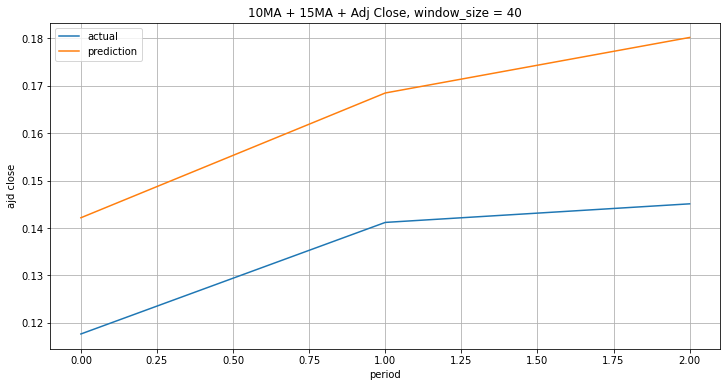

In [61]:
pred = model.predict(x_test)

plt.figure(figsize=(12,6))
plt.title('10MA + 15MA + Adj Close, window_size = 40')
plt.ylabel('ajd close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()